[Link to this document's Jupyter Notebook](./0415-PROJECT_Part2.ipynb)

# Project Part 2: Benchmark and Optimization

In this milestone you will provide a report which includes the results of your benchmark and optimization.  Your report will include a benchmark speeds on a single core and then a description of what you did to speed up the code and a graph of how much improvements you made over the benchmark.  Your final report should include the following:

- Project Title
- Motivating Image
- Abstract
- Methodology
- Timing Results
- Concluding Discussion and Future Work
- References


To help you out your instructor has provided the following template


---- START TEMPLATE ----

# Part 2 - Sample Lasso

By Filip Jevtic

&#9989; Replace the following with a picture that "defines" your project.  This could be software logo, an expected outcome of your project, or a graphical representation of the research area. Again, it is okay to use the picture from the proposal but it is also good to come up with a new unique picture.  

<img src="https://humantechnopole.it/wp-content/uploads/2020/08/shutterstock_314077820-1024x768.jpg" alt="Just a simple camera icon intended to be replaced with your image" width="50%">

Image from: https://humantechnopole.it/wp-content/uploads/2020/08/shutterstock_314077820-1024x768.jpg

---
# Abstract


This project is based in the domain of computational biology. It uses a customized lasso regression called Sample LASSO to impute gene expression profiles for microarray samples. The lasso algorithm is a regression analysis method that minimizes the sum of squared errors, performing both variable selection and regularization, which increases interpretability of a model.This is important for purposes in the medical field such as identifing diseases based on the gene expression profile. I picked this domain because it is one I am already familiar with, which meant that conceptually understanding the code was easier. Additionally, I picked this domain as opposed to something else because this program can make a real impact in the world. Computational science is used in biology to gain a greater understanding of the numbers and data that govern microbiology, while also providing computational methods to classify or impute data in it. What I did in this project is benchmark and test 2 different kinds of parallelization/optimization. I created benchmarks and concluded that I was able to speed the code up by about 30-40%.

---
# Methodology


The project is made up of 3 python scripts, 3 sbatch submission scripts. Each different parallelization method uses a separate version of all three. In total there are 3 sets of 3 python scripts/sbatch submission scripts. The methods/options implemented go as follows:
    1. Job array implementation for knitting and evaluation scripts, nodes = 1
    2. Job array implementation for knitting and evaluation scripts, nodes = # arrays
    3. Numba implementation with @jit
    4. Numba implementation with @jit(nopython=True)
    5. Numba implementation with @jit(nopython=True,parallel=True)
    6. Numba implementation with @njit(fastmath=True)
    7. Numba & Job array (nodes = 1, @jit)
    8. Standard serial implementation
    
The project is initially run on private, unaccessible research data, that is too big in size to push to Github. Therefore, I found worm data to use as a example when reproducing this code. What I already did is set the data used to the worm data, so you don't have to worry about changing anything. If you navigate to the main part of the repo, the entire script is run in one command. You need to change the beginning of the file name depending on your method. If you want to run in serial (original code), simply type 

```
    sbatch <insert>LASSO2_v2_trimmed_LINCS.sb
```
Notice the insert. If you want to run the original code, don't insert anything. If you want to run it with job arrays type in "jb_". (uses numba currently too. If you want to remove that, then crtl-f search through the 3 python files and comment out any @jit/njit used in the code.) If you want to run with numba only, type in "numba_". 

The first job submitting will submit many jobs that make all these models. After all the models are done, the knitting script will be submitted, which combines all the model data together into one array. Then, the evaluation script is called, which outputs a script of a metric for each test/val model created, allowing someone to graph it easily.

---
# Timing Results

Hardware: HPCC dev-intel 18

In [2]:
import matplotlib.pyplot as plt

I conducted the timing study for each script separately when doing it, which means the combined sum of the run times gives the total. I took an average of 10 runs for each method. I first plot the lasso timing study, which is the most computationally complex process. I used grep to get the longest run time out of the 165 jobs submitted, and recorded that value, because when evaluating the code, it's only as good as the longest iteration. The reason the times for jb 1 and jb 2 are the same is because nothing was changed in this script for the job array method (job array already set up and can't be touched because it is specific to the script design). It's interesting that the jit compilation took the least amount of time, 36% faster than the original code. The command is unique because numba chooses the best way to run the code, so the fact that it ran the shortest means numba knows what it's doing. However, the parallel option slowed the code down significantly, likely due to the fact that compile time increased. While execution time improved for sure, the compile time is still included in the runtime of the whole script, which is why it slowed down by 1.24 times.

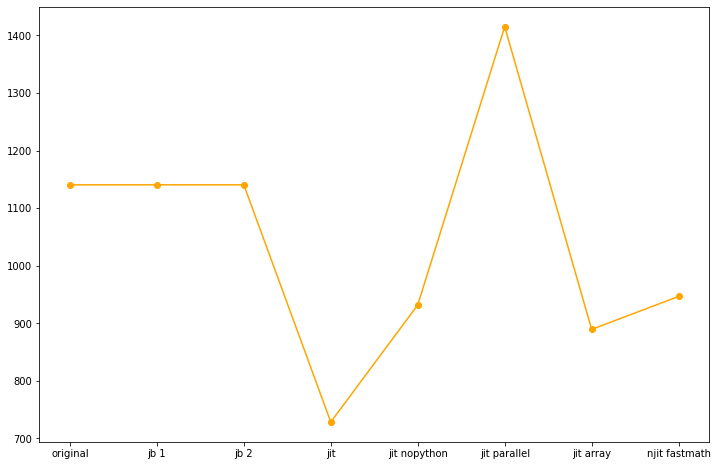

In [5]:
lasso = [1140.42,1140.42,1140.42,728.56,931.8,1414.97,889.422,946.63]
methods = ["original","jb 1","jb 2","jit","jit nopython","jit parallel","jit array","njit fastmath"]
knitting = [94.31,28.01,57.91,70.34,66.16,71.24,44.20,107.05]
eval = [71.44,58.62,54.327,87.65,99.68,93.9,52.3,187.97]
fig = plt.figure(figsize=(12,8))
plt.plot(methods,lasso,color = "orange")
plt.scatter(methods,lasso,color  = "orange")


Now taking a look at the knitting and evaluations, it's not surprising to see the job array improve performance significantly. I thought it was interesting that when nodes = 2, knitting performed worse than eval. When doing job arrays, I recorded the longest time for each pair of jobs for both eval and knitting. The fast math was surprisingly high, which like the lasso, probably takes a long time to compile and while run time is good, there's not enough data to make the run time any much faster than it already is. Another interesting thing to see was combining job array with nodes = 1 and jit didn't improve performance as much as I thought. I think jit is better when there is a lot of data. The first script requires the most resources so it makes sense why jit massively improved the run time.

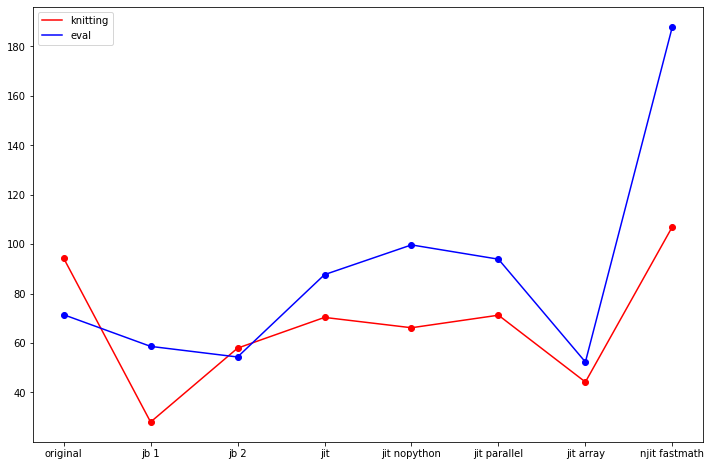

In [6]:
fig = plt.figure(figsize=(12,8))
plt.plot(methods,knitting,color = "red")
plt.plot(methods,eval,color = "blue")

plt.scatter(methods,knitting,color = "red")
plt.scatter(methods,eval,color = "blue")
plt.legend(["knitting","eval"])


The last thing to look at is the total times. Overall, jit was the fastest performing method, with jit_array in close second. jit parallel was by far the longest and least efficient method. It was interesting that fast math was faster than the benchmark and about the same as the job arrays, meaning that the inefficiencies in knitting and eval were made up for in lasso.

The code was sped up by a percentage of 32.12598666329805


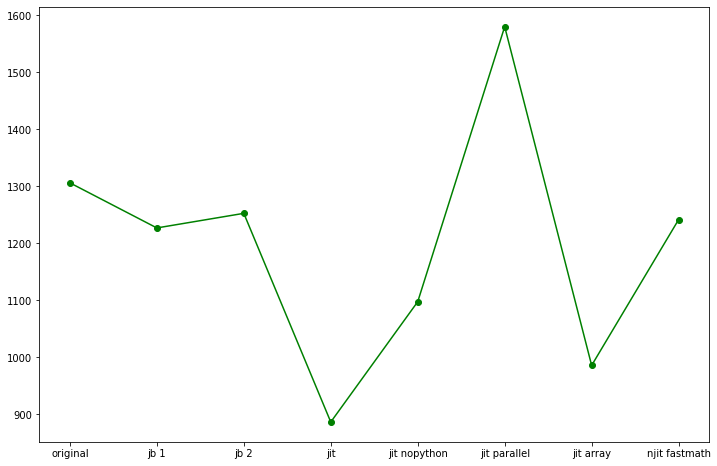

In [14]:
import numpy as np
summed = np.add(lasso,knitting)
summed = np.add(summed,eval)
print("The code was sped up by a percentage of", 100*(summed[0]-np.min(summed))/summed[0])
fig = plt.figure(figsize=(12,8))
plt.plot(methods,summed,color = "green")
plt.scatter(methods,summed,color = "green")

---
# Concluding Discussion and Future Work

Overall, I was able to determine methods and used benchmarks to show that I can speed the sampleLASSO model up by a maximum of 32%, using numba's jit optimization. The timing study showed that code that uses large amounts of data is improved by numba more than little data. With that said, the job array methods used show that job arrays can increase run time by as much as 70%, which was the case for knitting. The best method for eval was the numba jit job array with nodes = 1. It's interesting that each script had a different best method. This would imply that using the best method for each script would produce the fastest running script. With that in mind, the fastest sample lasso model would have a numba jit optimized lasso script, a job array nodes = 1 for the knitting script, and a numba jit job array nodes = 1 for the eval script.

It was very difficult to implement numba, because it is restricted heavily by the kind of functions and objects that can be used with it. Therefore, I was only able to add numba optimization for certain numpy array operations. It's interesting that the run time improved by so much from such a seemingly insignificant change to the code. Other things I tried to add was joblib, a parallization progam that optimizes scikit learn function. However, all the sklearn functions I used were incompatible with joblib unfortunately. Because of this, I was upset that aspects of the eval and knitting couldn't be optimized/parallelized with numba. I think if I were to try fully parallelizing those scripts, then it would be best to implement CUDA, which would be difficult.

Some results I found surprising were the fastmath and jit parallel functions. The fact that fastmath was the worst for eval/knitting but best for lasso proves that numba is good and only good for large amounts of data. However, parallel did not improve any run time, partly because there was nothing that could be parallelized with numba, just numpy operations that needed optimization. The run time for parallel would improve a lot if I had a for loop to use prange with. However, as mentioned earlier, I did not have compatible operations where I used a for loop. Another surprising result was why jit and job array combined didn't just become overall faster than everything: I expected the run times improvements to directly stack upon eachother. My thoughts are that because there were more jobs being submitted, it increased the number of jit compiles, which would negatively impact run time and thus it was not as fast as other methods. The last thing that I found interesting was that jit performed better than jit(nopython = True)/njit (same thing). The latter method converts the python to machine code, while with jit, numba selects the best way to optimize the program. I think this goes to show that the computer is better at determining how to optimize something than I am. 

Overall, I really enjoyed this project and learned a few important lessons about parallelization software.

---
# References

Ackowledgements to Jake Canfield, a coauthor of the sample lasso project.
https://www.biorxiv.org/content/10.1101/2020.03.30.016675v1.abstract

---- END TEMPLATE ----

-----
### Congratulations, you are done!

Now, you just need to create a second directory in your git repository and include your report as an md or ipynb file in the directory along with any additional figures and files needed to reproduce the results.  You instructor should already have your git repository and be able to pull in your changes. 

Written by Dr. Dirk Colbry, Michigan State University
<a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.

----